# Bioimage Analysis

## Table of Contents

1. Load Packages and Data
    * required packages
    * loading and handling image data
2. Preprocessing
    * gaussian smoothing
3. Thresholding
    * manual thresholding
    * automated threshold detection
    * adaptive thresholding
4. Masking
    * improve segmentation
    * component labeling
5. Cell Segmentation
    * seeding 
    * watershed expansion
6. Post Processing
    * remove border cells
    * find cell edges
    * quantitative measurements
7. Summary 
    * analysis and visuals
    * save outputs
    * batch processing
    * notes
    * watermark

## Load Packages and Data

In [154]:
# packages used in the notebook are loaded here.
# numerical array package
import numpy as np 
# image processing 
from skimage.io import imread
import scipy.ndimage as ndi
from skimage.filters.thresholding import threshold_otsu
from skimage.filters.thresholding import try_all_threshold
from skimage.filters import rank 
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.io import imsave
# plotting 
import matplotlib.pyplot as plt
%matplotlib inline 
# widget
from ipywidgets import interact
# accessing directory and os settings
import os
import sys 

In [97]:
# set up path and load image.
# base path and path
PROJ_ROOT = os.path.join(os.pardir)
# print(os.path.abspath(PROJ_ROOT))
image_path = os.path.join(PROJ_ROOT, 'BioimageAnalysis', 'data', 'cells2.tif') 
print(image_path)
# load the image
img = imread(image_path)

..\BioimageAnalysis\data\cells2.tif


Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (930, 780)
Loaded values are of type: uint8


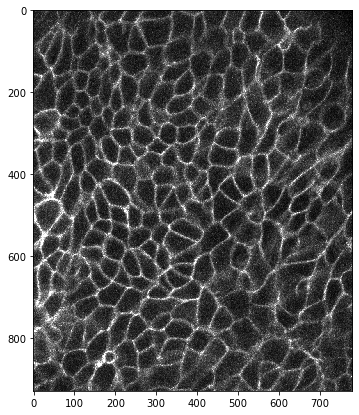

In [98]:
# check the image loaded okay
# info about the image
print("Loaded array is of type:", type(img)) # check type
print("Loaded array has shape:", img.shape) # check shape of image array
print("Loaded values are of type:", img.dtype) # check type of array values
# the image!
plt.figure(figsize=(7,7))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

## Preprocessing 
Perform Gaussian smoothing and view the result.

In [99]:
# sigma variable for smoothing factor
sigma = 3
#perform smoothing on image
img_smooth = ndi.filters.gaussian_filter(img, sigma)
# the smoothed image too!
fig, ax = plt.subplots(1,4, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(img_smooth, interpolation='none', cmap='gray')
ax[2].imshow(img_smooth[400:600, 200:400], interpolation='none', cmap='gray')
ax[3].imshow(img[400:600, 200:400], interpolation='none', cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Smoothed Image')
ax[2].set_title('Zoomed Raw Image')
ax[3].set_title('Zoomed Smoothed Image')
plt.show()

## Thresholding

### Manual Thresholding
First we will use an arbitrary threshold and apply it to the image.  Next we can optimize the threshold value by trying various values to get the best result.

In [100]:
# variable for manually setting threshold
threshold = 70
# perform thresholding on the smoothed image
img_thresh = img_smooth > threshold
# check the type
print(img_thresh.dtype)

bool


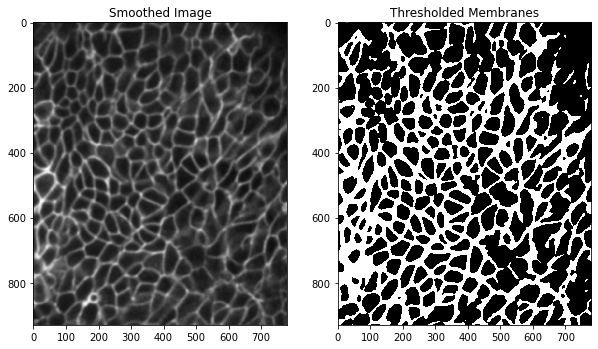

In [101]:
# the smooth and thresholded images
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(img_thresh, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed Image')
ax[1].set_title('Thresholded Membranes')
plt.show()

In [102]:
@interact(threshold=(10,250,5))
def select_threshold(threshold=100):
    # Thresholding
    img_thresh = img_smooth > threshold
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(img_thresh, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='threshold', max=250, min=10, step=5), Output()), _dom_â€¦

By looking at the image through the above interactive widget, we can see that a value that is too low or too high does not provide clear results.  However, when the threshold is optimized, we can see clear cell boundaries throughout the image.

Next we can try to automate threshold detection.

### Automated Thresholding

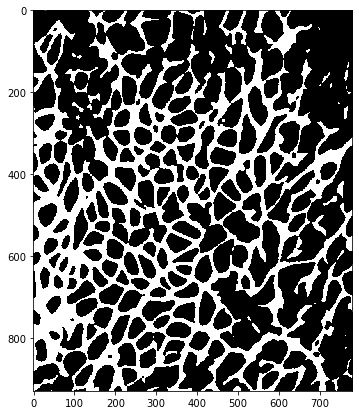

In [103]:
# perform automated theshold detection using otsu method
# calculate and apply threshold
threshold = threshold_otsu(img_smooth)
img_thresh = img_smooth > threshold
# view of automated threshold
plt.figure(figsize=(7,7))
plt.imshow(img_thresh, interpolation='none', cmap='gray')
plt.show()

The automated otsu method provided a very good result.  

Also available through the `skimage` package is the `try_all_threshold` function which automatically tests the threshold detection functions in `skimage.filters.thresholding`.  

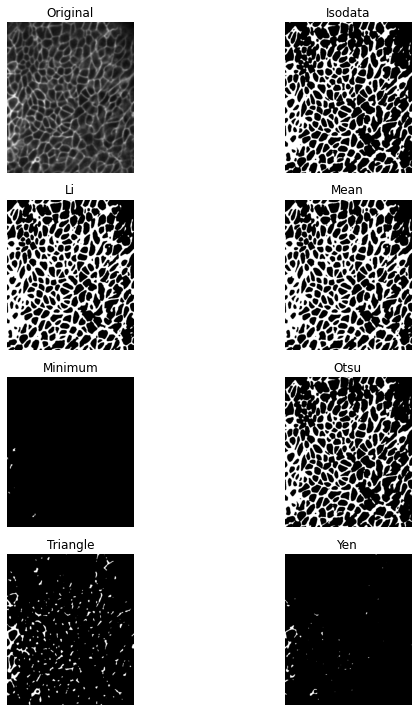

In [104]:
img_all = try_all_threshold(img_smooth, figsize=(10,10), verbose=False)

### Adaptive Thresholding 
Implement adaptive thresholding by using a strong `mean filter` with a circular SE to create the background image and use the background image for thresholding.  

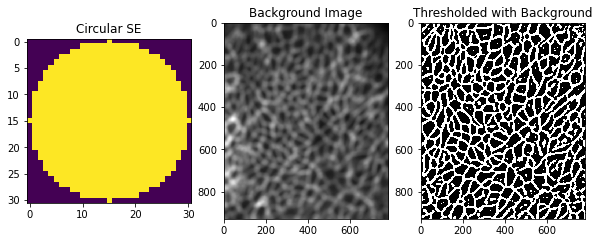

In [105]:
# create a stong mean filter with a circular SE to create background image
# Create SE
i = 31
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# create the background using a mean filter over the disc SE
bg = rank.mean(img_smooth, selem=SE)

# threshold the gaussian smoothed original image against the background image
img_back = img_smooth > bg

# view the circular SE and background image
fig, ax = plt.subplots(1, 3, figsize=(10,7))
ax[0].imshow(SE, interpolation='none')
ax[1].imshow(bg, interpolation='none', cmap='gray')
ax[2].imshow(img_back, interpolation='none', cmap='gray')
ax[0].set_title('Circular SE')
ax[1].set_title('Background Image')
ax[2].set_title('Thresholded with Background')
plt.show()

## Masking

### Binary Morphology
Improve the membrane segmentation using morphological operations.

In [106]:
# remove speckling with binary hole filling
img_back_fill = ~ndi.binary_fill_holes(~img_back)

In [107]:
# other morphological operations to further improve membrane mask
# new circular SE w better size
i = 15
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# reduce boundary artefact by padding with reflection
pad_size = i+1
img_padded = np.pad(img_back_fill, pad_size, mode='reflect')

# binary closing for rounding off membranes and closing gaps
img_final = ndi.binary_closing(img_padded, structure=SE)

# slice padded image back to original size
img_final = img_final[pad_size:-pad_size, pad_size:-pad_size]

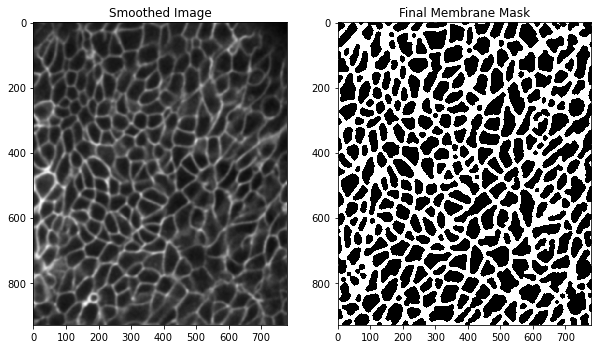

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(img_final, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed Image')
ax[1].set_title('Final Membrane Mask')
plt.show()

The difference between the smoothed and masked images is very clear and, unlike in the thresholded examples, the boundaries are clear even at the edges and there are not gaps present.  

### Component Labeling 
Next we can use membrane segmentation to label connected components using the `ndi.label` function from `ndimage`.

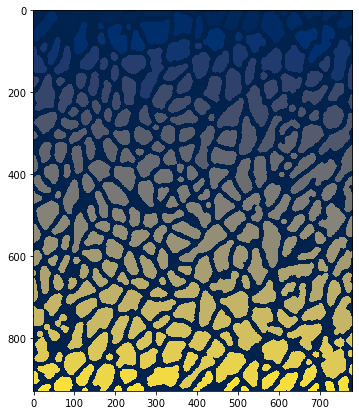

In [109]:
# label connected components
cell_labels, _ = ndi.label(~img_final)

# view the image and cell IDs (by color)
plt.figure(figsize=(7,7))
plt.imshow(cell_labels, interpolation='none', cmap='cividis')
plt.show()

## Cell Segmentation

### Seeding
Find seeds using the distance transform approach

In [110]:
# start with distance transform on membrane mask
dist_trans = ndi.distance_transform_edt(~img_final)
# smooth the distance transform
dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=5)

# get the local maxima from the distance transform
seeds = peak_local_max(dist_trans_smooth, indices=False, min_distance=10)

# use maximum_filter to dilate seeds, making them larger and easier to see
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

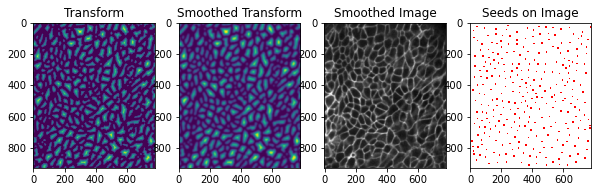

In [111]:
# view distance transform, smoothed transform, original image and seeds
fig, ax = plt.subplots(1, 4, figsize=(10,7))
ax[0].imshow(dist_trans, interpolation='none', cmap='viridis')
ax[1].imshow(dist_trans_smooth, interpolation='none', cmap='viridis')
ax[2].imshow(img_smooth, interpolation='none', cmap='gray')
ax[3].imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
ax[0].set_title('Transform')
ax[1].set_title('Smoothed Transform')
ax[2].set_title('Smoothed Image')
ax[3].set_title('Seeds on Image')
plt.show()

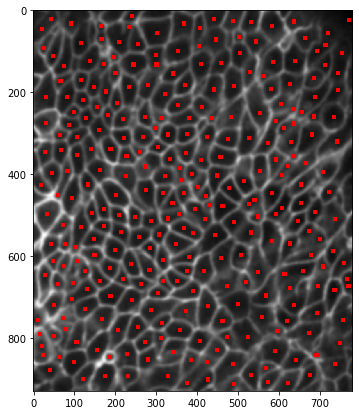

In [112]:
# overlay seeds on original image for clearer idea of where they are in the image
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
plt.show()

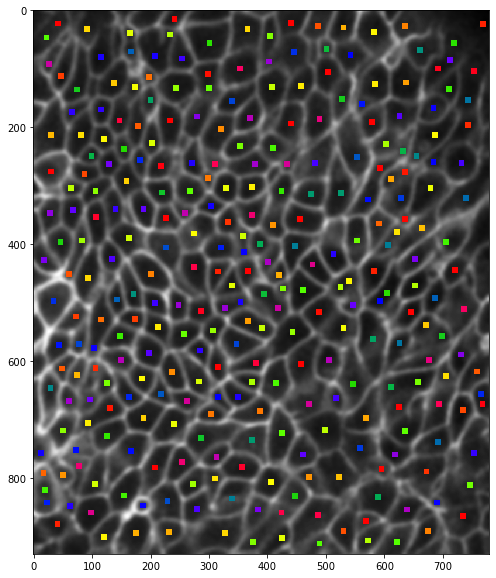

In [113]:
# label the seeds, using the connected component label, with unique ID 
seeds_labeled = ndi.label(seeds)[0]
# enlarge again for better viewing
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)

# view the labeled seeds on smoothed image
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), interpolation='none', cmap='prism')
plt.show()

### Watershed Expansion
Expand the seeds using watershed expansion using the `watershed` package from skimage.

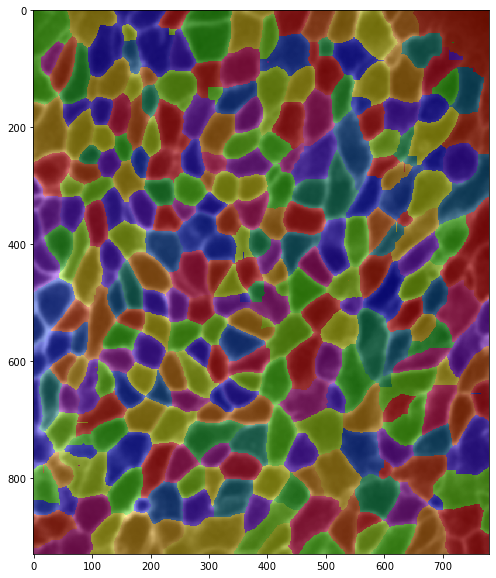

In [114]:
# perform watershed
ws = watershed(img_smooth, seeds_labeled)

# show the result as an overlay on the smoothed input.
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

Here we see a clearly segmented image.  Depending on the quality achieved at each step leading up to this, the final segmentation result may be over or under segmented.  While segmentation is never perfect, there is a balance that should be achieved between over/under segmentation.  If an image is over/under segmented, it will not be useful in addressing the biological question of interest.  

## Post Processing
Here we will remove the cells at the age of the image by iterating through all of the cells in the image and removing any that touch the edge.

In [115]:
# create image border mask
border_mask = np.zeros(ws.shape, dtype=np.bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

# remove cells at border
# start with copy of the array since we will modify the array
ws_copy = np.copy(ws)
# iterate over each ID and create mask with current cell, 
# then test if cell mask and border mask intersect. 
# If it does, delete it.
for cell_ID in np.unique(ws):
    cell_mask = ws==cell_ID
    cell_border_overlap = np.logical_and(cell_mask, border_mask)
    total_overlap_pixels = np.sum(cell_border_overlap)
    if total_overlap_pixels > 0:
        ws_copy[cell_mask] = 0
# relabel remaining cells from 1 to number of cells, where 0 is background
for new_ID, cell_ID in enumerate(np.unique(ws_copy)[1:]):
    ws_copy[ws_copy==cell_ID] = new_ID + 1


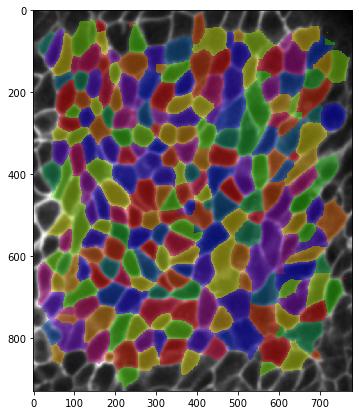

In [116]:
# view the image with border cells removed, original image as background
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(ws_copy, mask=ws_copy==0), interpolation='none', cmap='prism', alpha=0.4)
plt.show()

### Find Cell Edges
Create a labeled mask of cell edges

In [122]:
# create a zero array of appropriate size
edges = np.zeros_like(ws_copy)

# iterate over all IDs eroding the cell mask by 1 pixel to make edge mask
# store edges in empty mask created above
for cell_ID in np.unique(ws_copy)[1:]:
    cell_mask = ws_copy==cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=2) # Increase iterations to make boundary wider!
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    edges[edge_mask] = cell_ID


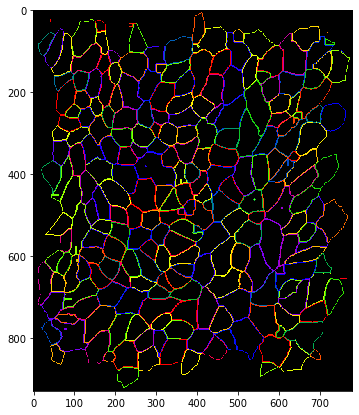

In [123]:
# view the edges
plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(edges), cmap='gray', vmin=0, vmax=1)  # Simple black background
plt.imshow(np.ma.array(edges, mask=edges==0), interpolation='none', cmap='prism')
plt.show()

### Quantitative Measurements
Find cell attributes for each cell ID. 

In [136]:
# create a dict to hold measurements for each cell
results = {"cell_id": [],
           "intensity_mean": [],
           "intensity_membrane_mean": [],
           "cell_area": [],
           "cell_edge": []}

# for each cell ID, mask the current cell and edge to get measurements
for cell_id in np.unique(ws_copy)[1:]:
    cell_mask = ws_copy==cell_id
    edge_mask = edges==cell_id
    results["cell_id"].append(cell_id)
    results["intensity_mean"].append(np.mean(img[cell_mask]))
    results["intensity_membrane_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

In [137]:
# results
for key in results.keys():
    print(key, ':', results[key][4:5], '\n') # slice many or one cell result

cell_id : [5] 

intensity_mean : [33.416666666666664] 

intensity_membrane_mean : [33.416666666666664] 

cell_area : [12] 

cell_edge : [12] 



## Summary 

### Resulting Analysis and Visuals
Final analysis of processed image.

In [138]:
# print summary stats
def print_summary(data):
    print( "  Mean:    {:7.2f}".format(np.mean(data))   )
    print( "  Stdev:   {:7.2f}".format(np.std(data))    )
    print( "  Max:     {:7.2f}".format(np.max(data))    )
    print( "  Min:     {:7.2f}".format(np.min(data))    )
    print( "  Median:  {:7.2f}".format(np.median(data)) )
    
# call function to print summary for each cell
for key in results.keys():
    print( '\n'+key )
    print_summary(results[key])


cell_id
  Mean:     128.00
  Stdev:     73.61
  Max:      255.00
  Min:        1.00
  Median:   128.00

intensity_mean
  Mean:      69.78
  Stdev:     14.31
  Max:      144.29
  Min:       25.25
  Median:    68.69

intensity_membrane_mean
  Mean:     117.96
  Stdev:     25.14
  Max:      217.30
  Min:       25.25
  Median:   119.70

cell_area
  Mean:    2178.65
  Stdev:   1215.64
  Max:     5450.00
  Min:        2.00
  Median:  2163.00

cell_edge
  Mean:     325.19
  Stdev:    132.48
  Max:      637.00
  Min:        2.00
  Median:   334.00


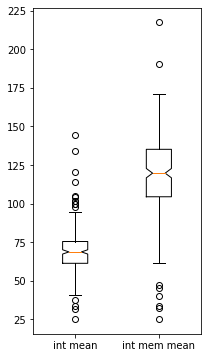

In [142]:
# boxplot of 
plt.figure(figsize=(3,6))
plt.boxplot([results['intensity_mean'], results['intensity_membrane_mean']], 
            labels=['int mean', 'int mem mean'],
            widths=0.3, notch=True)
plt.show()

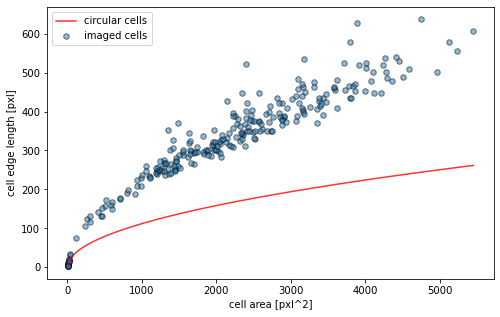

In [145]:
# scatter plot of cell outline length over cell area 
# to see how circumference scales with area
plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
            edgecolor='k', s=30, alpha=0.5)
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")

cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circular cells', 'imaged cells'], loc=2, fontsize=10)
plt.show()


General, the observed cells don't deviate all that much from the circular case.  However, some cells have a smaller outline than the circumference of a circle of equivalent area. This is clearly a mathematically impossibility.  A possible reason could be that the measures are taken in pixels, which leads to a discretization error. It could be fixed by "meshing" the cell outline and interpolating a more accurate measurement of circumference.

In [149]:
# linear fit of membrane intensity over cell area
# Compute linear fit
from scipy.stats import linregress
linfit = linregress(results["cell_area"], results["intensity_membrane_mean"])

# Print all the results
linprops = ['slope','interc','rval','pval','stderr']
for index,prop in enumerate(linprops):
    print( prop, '\t', '{:4.2e}'.format(linfit[index]) )
    
# overlay linear fit onto scatter plot
# selected values
x_vals = [min(results["cell_area"]), max(results["cell_area"])]
y_vals = [linfit[0] * x_vals[0] + linfit[1], linfit[0] * x_vals[1] + linfit[1]]
# make plot
plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["intensity_membrane_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)
# labeling
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")
plt.show()

slope 	 6.08e-03
interc 	 1.05e+02
rval 	 2.94e-01
pval 	 1.80e-06
stderr 	 1.24e-03


The above fit returns a highly significant p-value but a very low correlation coefficient (rval).  We would not expect a linear correlation like this to exist in this data.  

It is clear that a linear fit on this data is not meaningful based on the rval (or the scatter plot also shows this).  Instead, it would make sense to report effect sizes.  

Oversegmentation is an important source of bias here.  If a cell is oversegmented, it will be considered as 2 or 3 cells.  These will naturally have a lower cell area and lower membrane intensity because some of their edges are actually not membranes.  Thus, they will fall into the bottom left of the plot and distort the data.  

In [153]:
# map the cell area onto image as a heatmap
# scale cell area data to 8bit
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255
# initialize new image zero array
area_map = np.zeros_like(ws_copy, dtype=np.uint8) 
# iterate over segmented cells and cell IDs
# mask current cell and assign rescaled area
for index, cell_id in enumerate(results["cell_id"]):
    area_map[ws_copy==cell_id] = areas_8bit[index]

# view result with semi-transparent mask, excluding outliers
# Mask of outliers (the largest and smallest 5% of all cells)
outlier_mask = np.logical_or(area_map > np.percentile(areas_8bit, 95),
                             area_map < np.percentile(areas_8bit, 5))

# Mask of all regions to leave blank (outliers + image boundary cells)
full_mask = np.logical_or(area_map==0, outlier_mask)

# Create the plot
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(area_map, mask=full_mask),
           interpolation='none', cmap='viridis', alpha=0.6)
plt.show()

### Save Outputs
Write the generated data to output file.

In [159]:
# tiff save
imsave("report/edges.tif", edges.astype(np.uint16))
imsave("report/mask_wo_outliers.tif", full_mask.astype(np.uint16))

C:\Users\Hailey\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: report/edges.jpg is a low contrast image
  """Entry point for launching an IPython kernel.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Hailey\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: report/mask_wo_outliers.jpg is a low contrast image
  
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


In [158]:
# pdf of png save
plt.scatter(results["cell_area"], results["intensity_membrane_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")

# Save as png and pdf
plt.savefig('report/scatterFit.png')
plt.savefig('report/scatterFit.pdf')
plt.clf()  # Clear the figure buffer

<Figure size 432x288 with 0 Axes>

In [160]:
# dict save
with open('report/results.txt','w') as outfile:
    header_string = '\t'.join(results.keys()) + '\n'
    outfile.write(header_string)

    for index in range(len(results['cell_id'])):
        data_string = '\t'.join([str(results[key][index]) for key in results.keys()]) + '\n'
        outfile.write(data_string)

### Batch Processing
Convert the work above into a single pipeline function.  Call function below.

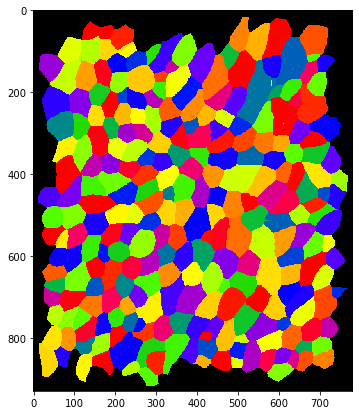

In [165]:
from batch_processing import run_pipeline
# call batch_processing on single image.
pip_seg, pip_results = run_pipeline(r"data", r'cells1.tif')

plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(pip_seg), interpolation='none', cmap='gray', vmax=1)  # Simple black background
plt.imshow(np.ma.array(pip_seg, mask=pip_seg==0), interpolation='none', cmap='prism')
plt.show()

In [172]:
# call batch_processing on directory of images
dirpath = r"data"
from os import listdir
filelist = listdir(dirpath)
# get all files
target_files = []
for fname in filelist:
    if fname.endswith('.tif'):
        target_files.append(fname)
print(target_files)
# filter for relevant files
import re
target_pattern = re.compile("^cells\d+\.tif$")
target_files = [fname for fname in filelist if target_pattern.match(fname)]
print(target_files)
# iterate over files and apply batch_processing
all_seg = {}
all_results = {}
for fname in target_files:
    pip_seg, pip_results = run_pipeline(dirpath, fname)
    all_seg[fname] = pip_seg
    all_results[fname] = pip_results
# plot results for all tiff files explored.
plt.figure(figsize=(8,5))

colors = ['blue','red']
for key, color in zip(sorted(all_results.keys()), colors):
    plt.scatter(all_results[key]["cell_area"], all_results[key]["cell_edge"],
                edgecolor='k', c=color, s=30, alpha=0.5, label=key)
    
plt.legend()
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")
plt.show()

['cells1.tif', 'cells2.tif']
['cells1.tif', 'cells2.tif']


### Notes

The techniques and functions herein have been utilized for cellular analysis in a laboratory setting.  This work was implemented as a modified version of a bioimage analysis tutorial by Jonas Hartmann.  

### Watermark

In [177]:
%load_ext watermark
%watermark -v -a HGryk -m -p numpy
%watermark -p skimage
%watermark -p scipy
%watermark -p matplotlib
%watermark -p ipywidgets
%watermark -p  sys

HGryk 

CPython 3.7.7
IPython 7.18.1

numpy 1.19.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 8.1
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
skimage 0.16.2
scipy 1.5.2
matplotlib 3.3.2
ipywidgets 7.5.1
sys 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
